In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For showing plots
import scipy.stats as sts
import scikit_posthocs as sp
import statsmodels.stats as stm
from statsmodels.graphics.gofplots import qqplot

C:\Users\marti\AppData\Local\Temp\ipykernel_10532\1067413810.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('../EFIplus_medit.zip',compression='zip', sep=";")

1. Check the if any of the continuous environmental variables in the EFIplus_medit dataset (Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul) would require a data transformation in order to apply parametric tests.

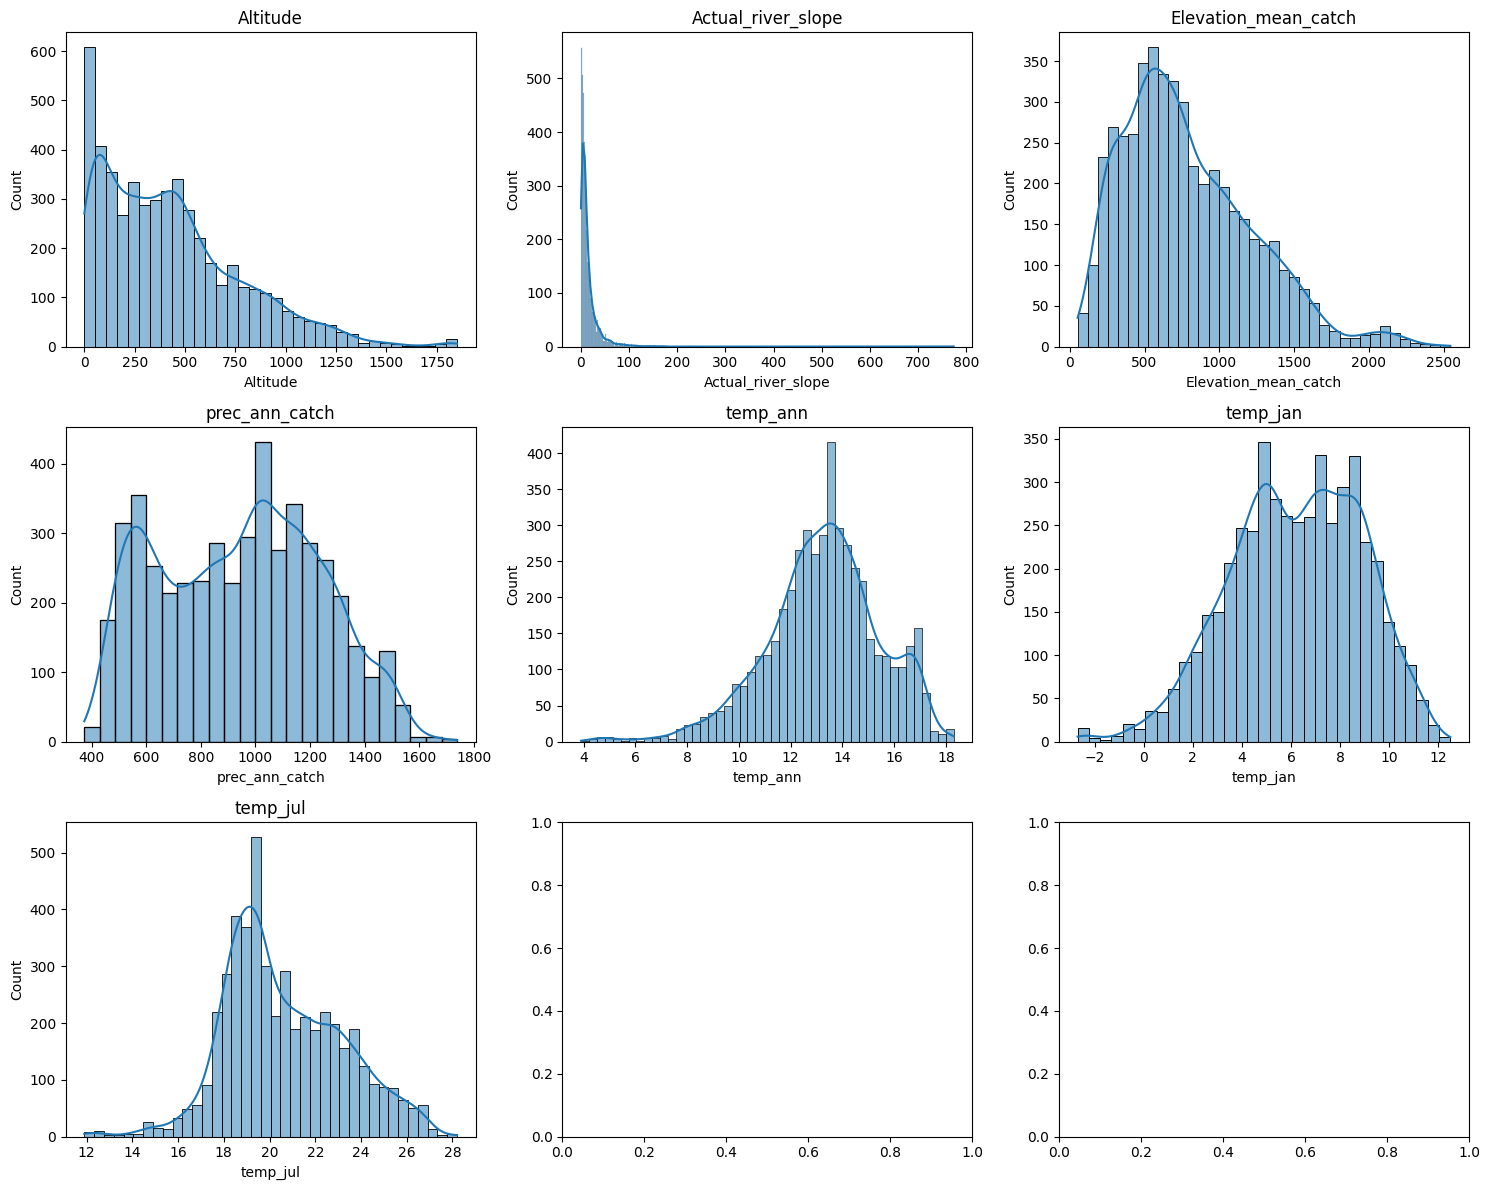

In [3]:
# Select continuous environmental variables
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

# Visualize distributions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, var in enumerate(continuous_vars):
    row = i // 3
    col = i % 3
    sns.histplot(df[var], kde=True, ax=axes[row, col])
    axes[row, col].set_title(var)
plt.tight_layout()
plt.show()

2. Apply the appropriate data transformation and check the new distributions.

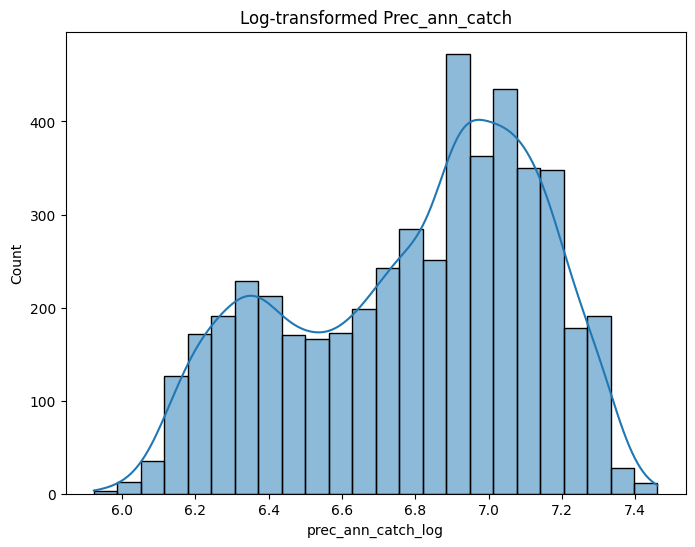

In [4]:
# Apply transformation (e.g., log transformation) to skewed variables
df['prec_ann_catch_log'] = np.log(df['prec_ann_catch'])

# Visualize the transformed distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['prec_ann_catch_log'], kde=True)
plt.title('Log-transformed Prec_ann_catch')
plt.show()

3. Create a column with the total number of species present (the species richness) in each sampling site (the first species in the dataset is ‘Abramis brama’ and all the columns to the right are all species).


In [5]:
# Extract species columns
species_columns = df.columns[7:]

# Calculate species richness
df['species_richness'] = df[species_columns].apply(lambda row: sum(row.notnull()), axis=1)

4. Check the existence of bivariate outliers in the relationship between Mean Annual Temperature 
(‘temp_ann’) and species richness using an appropriate plot. Run a bivariate isolation forest to detect 
outliers and plot the result.

In [6]:
from sklearn.ensemble import IsolationForest

df_cleaned = df.dropna(subset=['temp_ann', 'species_richness'])


In [7]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df.drop(df.iloc[:,5:15], axis=1, inplace=True)

# let's rename some columns so that they make sense
#df.rename(columns={'Sum of Run1_number_all':'Total_fish_individuals'}, inplace=True) # inplace="True" means that df will be updated

# for sake of consistency, let's also make all column labels of type string
df.columns = list(map(str, df.columns))

In [8]:
# Check column names in cleaned data
print(df_cleaned.columns)

# Check data types
print(df_cleaned.dtypes)

Index(['Site_code', 'Latitude', 'Longitude', 'Country', 'Catchment_name',
       'Galiza', 'Subsample', 'Calib_EFI_Medit', 'Calib_connect',
       'Calib_hydrol',
       ...
       'Squalius torgalensis', 'Thymallus thymallus', 'Tinca tinca',
       'Zingel asper', 'Squalius sp', 'Barbatula sp', 'Phoxinus sp',
       'Iberochondrostoma_sp', 'prec_ann_catch_log', 'species_richness'],
      dtype='object', length=166)
Site_code                object
Latitude                float64
Longitude               float64
Country                  object
Catchment_name           object
                         ...   
Barbatula sp              int64
Phoxinus sp               int64
Iberochondrostoma_sp      int64
prec_ann_catch_log      float64
species_richness          int64
Length: 166, dtype: object


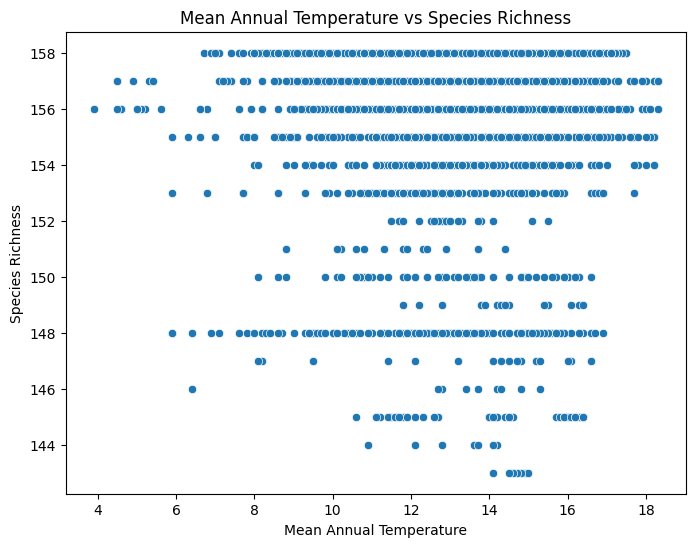

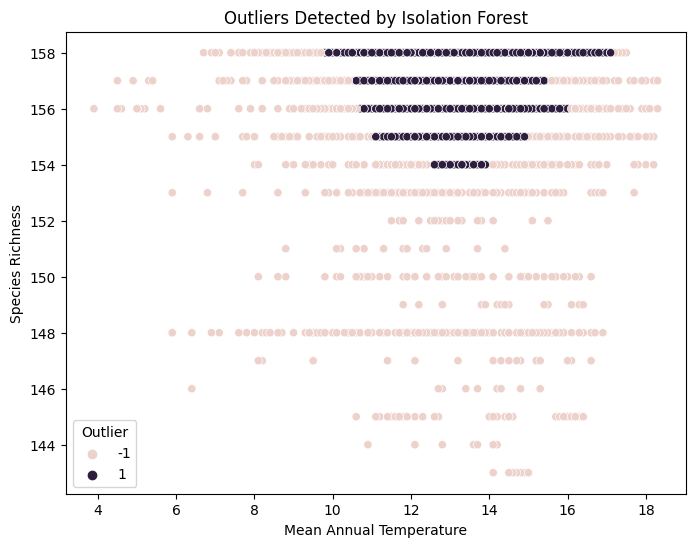

In [10]:

# Plot the relationship between temp_ann and species richness
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temp_ann', y='species_richness', data=df)
plt.title('Mean Annual Temperature vs Species Richness')
plt.xlabel('Mean Annual Temperature')
plt.ylabel('Species Richness')
plt.show()

# Fit isolation forest
X = df_cleaned[['temp_ann', 'species_richness']]
isolation_forest = IsolationForest(contamination='auto', random_state=42)
outliers = isolation_forest.fit_predict(X)

# Predict outliers
outliers = isolation_forest.predict(X)

# Plot outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temp_ann', y='species_richness', data=df_cleaned, hue=outliers)
plt.title('Outliers Detected by Isolation Forest')
plt.xlabel('Mean Annual Temperature')
plt.ylabel('Species Richness')
plt.legend(title='Outlier')
plt.show()